In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import *
from skimage.filters import *
from skimage.feature import *
from skimage.util import invert
from skimage.transform import rotate, resize, hough_line, hough_line_peaks
from skimage.morphology import disk
from skimage.measure import find_contours
import os
from scipy import ndimage as nd
from scipy.signal import find_peaks
from scipy.integrate import trapezoid

In [2]:
images_path = os.path.join('dataset', 'images')
DS = pd.read_csv(os.path.join('dataset', 'dataset.csv'))

def get(filename):
    return np.array(Image.open(os.path.join(images_path, filename)))

def by_id(i):
    return get(f'{i}.jpg')

def random_images(k=1, names=False):
    fnames = np.random.choice(os.listdir(images_path), k)
    images = tuple(map(get, fnames))
    if names: return images, fnames
    else: return images

def fft2d(image):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image)))

def ifft2d(image):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(image)))

def peaks_filter(x:np.array, y:np.array, peaks:np.array, k:int=1):
    ypeaks = y[peaks]
    max_peak = peaks[ypeaks == ypeaks.max()]
    for _ in range(k-1):
        max_peak = peaks[ypeaks == ypeaks[np.isin(ypeaks, y[x < x[max_peak][0]])].max()]
    return max_peak

def pixel_scale(image:np.array):
    fft = np.abs(fft2d(image))
    xfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[0], 1))
    yfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[1], 1))
    
    ymean = np.mean(fft, axis=1)
    xmean = np.mean(fft, axis=0)
    
    (ypeaks, _), (xpeaks, _) = find_peaks(ymean), find_peaks(xmean)
    Py = peaks_filter(yfreqs, ymean, ypeaks, 2)
    Px = peaks_filter(xfreqs, xmean, xpeaks, 2)
    
    return np.abs(xfreqs[Px][0]), np.abs(yfreqs[Py][0])

def pixel_scale_1d(sig1d:np.array):
    fft = np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sig1d))))
    freqs = np.fft.ifftshift(np.fft.fftfreq(len(fft), 1))
    
    peaks, _ = find_peaks(fft)
    P = peaks_filter(freqs, fft, peaks, 2)
    
    return np.abs(freqs[P][0])

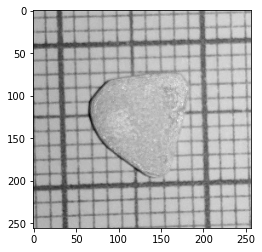

In [589]:
image = by_id(168)
#images, filenames = random_images(names=True)
#image = resize(np.array(Image.open('44.502  mm2_IA_253.jpg')), (200, 200))
#image = images[0]
#filename = filenames[0]
#image = random_images()[0]
img = rgb2gray(image)
plt.imshow(img, cmap='gray')

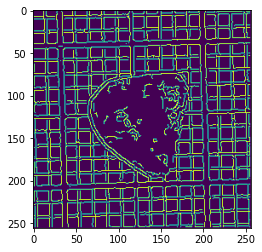

In [590]:
plt.imshow(canny(img))

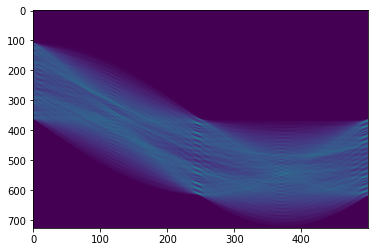

In [591]:
hspace, angles, dists = hough_line(canny(img), np.linspace(-np.pi/2, np.pi/2, 500))
plt.imshow(hspace, aspect='auto')

In [592]:
h_peaks, angles, dists = hough_line_peaks(hspace, angles, dists)

In [593]:
slopes = np.degrees(angles + np.pi/2)
slope_values = np.unique(slopes)
probs = np.array([np.sum(slopes == val) for val in slope_values])
probs

array([14,  1,  6,  9,  1])

In [594]:
img_slope = slope_values[probs == probs.max()][0]
img_slope

88.37675350701403

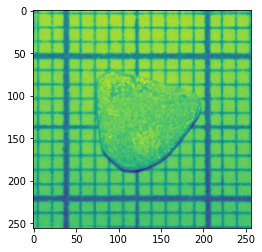

In [595]:
rot_img = rotate(img, img_slope, mode='reflect')
plt.imshow(rot_img)

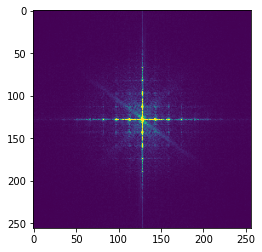

In [596]:
ifft = fft2d(rot_img)
fft = np.abs(ifft)
freqs = np.stack(np.meshgrid(
    np.fft.ifftshift(np.fft.fftfreq(img.shape[0])),
    np.fft.ifftshift(np.fft.fftfreq(img.shape[1]))
), axis=2)
plt.imshow(fft, vmax=fft.max()*0.005)

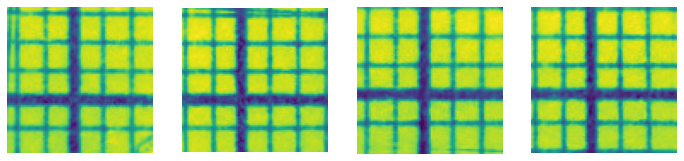

In [597]:
i, j = rot_img.shape
M = 3
patchs = (
    rot_img[:i//M, :j//M],
    rot_img[:i//M, -j//M:],
    rot_img[-i//M:, :j//M],
    rot_img[-i//M:, -j//M:]
)
_, axs = plt.subplots(1, 4, figsize=(12, 3))
for ax, p in zip(axs, patchs):
    ax.imshow(p)
    ax.axis('off')
plt.show()

In [598]:
Fx, Fy = np.apply_along_axis(pixel_scale_1d, 0, rot_img), np.apply_along_axis(pixel_scale_1d, 1, rot_img)
(fx, d_fx), (fy, d_fy) = (np.median(Fx[Fx > 0.02]), np.std(Fx)), (np.median(Fy[Fy > 0.02]), np.std(Fy))
fx, fy

(0.05859375, 0.05859375)

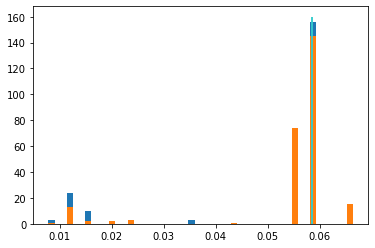

In [599]:
plt.hist(Fx, bins=50)
plt.hist(Fy, bins=50)
plt.vlines(fx, 0, 160, color='red')
plt.vlines(fy, 0, 160, color='cyan')
plt.show()

In [600]:
kernel_x = gabor_kernel(fx, theta=0)
kernel_y = gabor_kernel(fy, theta=np.pi/2)

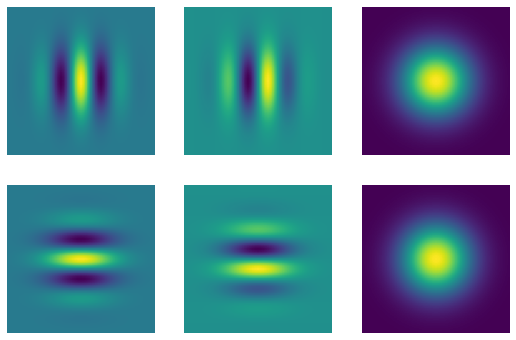

In [601]:
fig, axs = plt.subplots(2, 3, figsize=(9, 6))

for i, kaxis in enumerate([kernel_x, kernel_y]):
    for j, part in enumerate([np.real, np.imag, np.abs]):
        axs[i][j].imshow(part(kaxis))
        axs[i][j].axis('off')
        
plt.show()

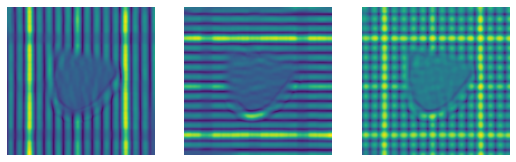

CPU times: total: 906 ms
Wall time: 1.76 s


In [610]:
%%time
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

xreal, ximag = gabor(rot_img, fx, 0, n_stds=1)
yreal, yimag = gabor(rot_img, fy, np.pi/2, n_stds=1)
gabor_x, gabor_y = np.sqrt(xreal**2 + ximag**2), np.sqrt(yreal**2 + yimag**2)
filtered = gabor_x + gabor_y

#filtered = nd.median_filter(nd.minimum_filter(gabor_x + gabor_y, footprint=disk(5)), footprint=disk(5))
#filtered = nd.maximum_filter(nd.minimum_filter(gabor_x + gabor_y, footprint=disk(5)), footprint=disk(5))
#filtered = nd.median_filter(nd.maximum_filter(nd.minimum_filter(np.sqrt(gabor_x) + np.sqrt(gabor_y), footprint=disk(5)), footprint=disk(5)), footprint=disk(5))

ax1.imshow(gabor_x)
ax2.imshow(gabor_y)
ax3.imshow(filtered)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

plt.show()

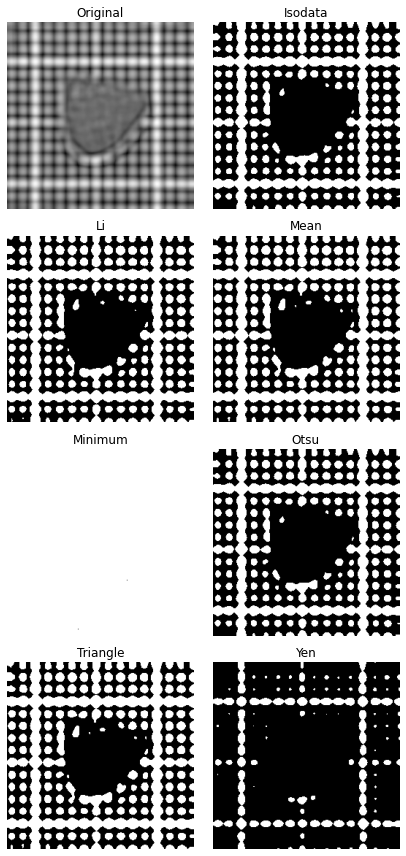

In [611]:
try_all_threshold(filtered, figsize=(6, 12), verbose=False)
plt.show()

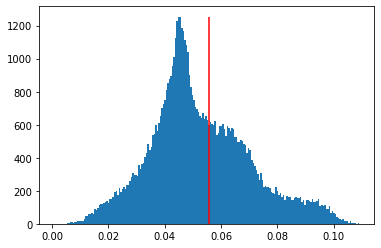

In [614]:
threshold = threshold_isodata(filtered, nbins=200) 
hist, bins, _ = plt.hist(filtered.flat, bins=200)
plt.vlines(threshold, 0, hist.max(), color='red')
plt.show()

33.9752197265625


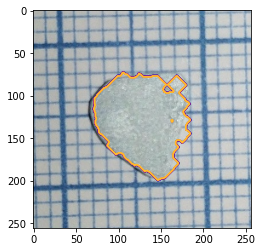

In [613]:
plt.imshow(image)
mask = filtered < threshold
mask = nd.binary_opening(mask, iterations=10)
#mask = nd.binary_closing(mask, iterations=5)
#mask = nd.binary_dilation(mask, iterations=1)
print(np.sum(mask)*fx*fy) #float(DS.loc[DS.filename == filename].area))
plt.contour(rotate(mask, -img_slope), cmap='plasma')

In [176]:
(49.2 - 43.02)/49.2*100

12.560975609756097

315.jpg, 257.jpg, 42.jpg, 111.jpg, 348.jpg, 320.jpg, 29.jpg, 327.jpg, 69.jpg, 249.jpg, 129.jpg, 125.jpg, 273.jpg, 180.jpg, 42.jpg, 223.jpg, 74.jpg, 55.jpg, 98.jpg, 181.jpg, 

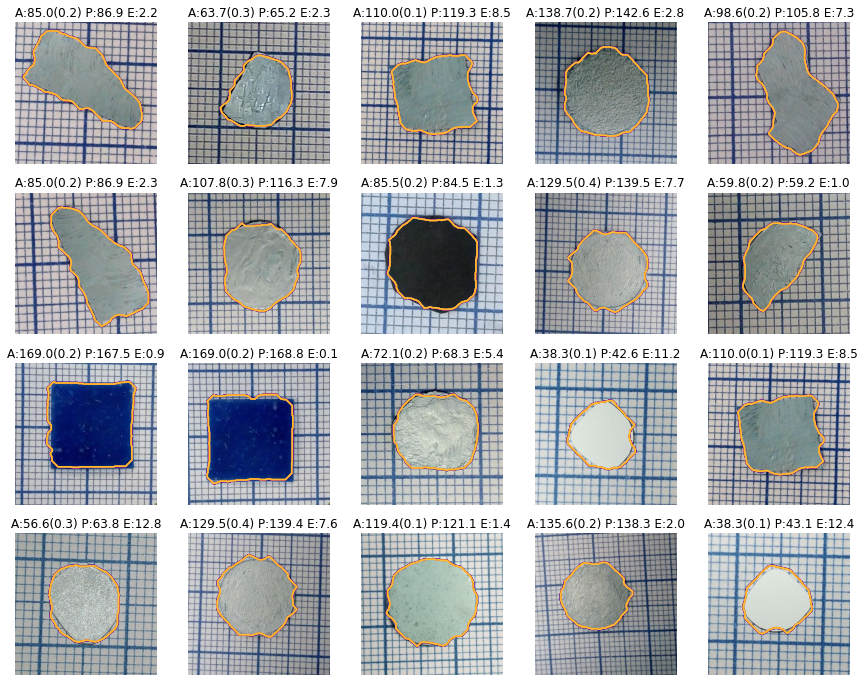

In [620]:
n = 5
r = 4
fig, axs = plt.subplots(r, n, figsize=(15, 3*r))
axs = axs.flatten()

for i, (image, name) in enumerate(zip(*random_images(r*n, names=True))):
    print(name, end=', ')
    
    img = rgb2gray(image)
    
    _, angles, _ = hough_line_peaks(*hough_line(canny(img), np.linspace(-np.pi/2, np.pi/2, 500)))
    slopes = np.degrees(angles + np.pi/2)
    slope_values = np.unique(slopes)
    probs = np.array([np.sum(slopes == val)/len(slopes) for val in slope_values])
    img_slope = slope_values[probs == probs.max()][0]
    img = rotate(img, img_slope, mode='reflect')
    
    Fx = np.apply_along_axis(pixel_scale_1d, 0, image)
    Fy = np.apply_along_axis(pixel_scale_1d, 1, image)
    fx, fy = np.median(Fx[Fx > 0.025]), np.median(Fy[Fy > 0.025])
    std_fx, std_fy = np.std(Fx[Fx > 0.025]), np.std(Fy[Fy > 0.025])
    
    '''j, k = img.shape
    patchs = (
        img[:j//4, :k//4],
        img[:j//4, -k//4:],
        img[-j//4:, :k//4],
        img[-j//4:, -k//4:]
    )
    #F = np.array([pixel_scale(patch) for patch in patchs])
    F = np.concatenate(np.array([[np.apply_along_axis(pixel_scale_1d, 0, patch), np.apply_along_axis(pixel_scale_1d, 1, patch)]
          for patch in patchs]), axis=1)
    fx, fy = np.median(F, axis=1)
    std_fx, std_fy = np.std(F, axis=1)'''
    
    xreal, ximag = gabor(img, fx, 0, n_stds=3)
    yreal, yimag = gabor(img, fy, np.pi/2, n_stds=3)
    filtered = np.sqrt(xreal**2 + ximag**2) + np.sqrt(yreal**2 + yimag**2)
    
    #filtered = nd.minimum_filter(filtered, footprint=disk(5))
    #filtered = nd.maximum_filter(filtered, footprint=disk(5))

    mask = filtered < threshold_isodata(filtered, nbins=200)
    mask = nd.binary_opening(mask, iterations=10)
    mask = nd.binary_closing(mask, iterations=5)
    mask = nd.binary_dilation(mask, iterations=1)
    mask = rotate(mask, -img_slope)
    
    axs[i].imshow(image)
    axs[i].contour(mask, cmap='plasma')
    
    area = float(DS.loc[DS.filename == name].area)
    area_pixel = np.sum(mask)
    predict = area_pixel*fx*fy
    erro_rel_pixel = np.sqrt(fy**2 * std_fx**2 + fx**2 * std_fy**2)*100
    
    axs[i].set_title(f'A:{area:.1f}({erro_rel_pixel:.1f}) P:{predict:.1f} E:{(np.abs(area-predict)/area*100):.1f}')
    axs[i].axis('off')
    
plt.show()

$$A = A_pf_xf_y$$

$$\Delta A = \sqrt{
    \left(\dfrac{\partial A}{\partial A_p}\Delta A_p\right)^2+
    \left(\dfrac{\partial A}{\partial f_x}\Delta f_x\right)^2+
    \left(\dfrac{\partial A}{\partial f_y}\Delta f_y\right)^2
}$$

$$\Delta A = \sqrt{
    \left(f_xf_y\Delta A_p\right)^2+
    \left(A_pf_y\Delta f_x\right)^2+
    \left(A_pf_x\Delta f_y\right)^2
}$$